In [1]:
from deep_traffic_generation.tcvae_pairs import TCVAE_Pairs
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset, TrafficDatasetPairs
from traffic.core import Traffic

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
from os import walk

In [2]:
dataset = TrafficDatasetPairs.from_file(
    ("../deep_traffic_generation/data/training_datasets/landings_south_LFPO_06.pkl", "../deep_traffic_generation/data/training_datasets/takeoffs_south_LFPO_07.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    # scaler=None,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [3]:
path = "../deep_traffic_generation/lightning_logs/tcvae_pairs/version_4/"

t = PairsVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) 

In [4]:
#Test for taking max element-wise
import torch.nn as nn

x1 = torch.randn(1000, 64)
x2 = torch.randn(1000, 64)

x = torch.cat((x1.unsqueeze(2),x2.unsqueeze(2)), dim = 2)
x = nn.MaxPool2d((1, 2), stride=(1,1))(x).squeeze(2)

# Latent Space

In [6]:
h1 = t.VAE.encoder_traj1(dataset.data1)
h2 = t.VAE.encoder_traj2(dataset.data2)
# h = torch.cat((h1, h2, torch.unsqueeze(dataset.delta_t, 1)), dim = 1)
h = torch.cat((h1, h2), dim = 1)
# h = torch.cat((h1.unsqueeze(2),h2.unsqueeze(2)), dim = 2)
# h = nn.MaxPool2d((1, 2), stride=(1,1))(h).squeeze(2)

# h = t.VAE.encoder_delta_t(h)
q = t.VAE.lsr(h)

In [7]:
print(t.VAE.scale_traj1, t.VAE.scale_traj2)

Parameter containing:
tensor([0.0107], requires_grad=True) Parameter containing:
tensor([0.0070], requires_grad=True)


In [6]:
t.VAE.lsr.prior_means

tensor([[ 8.3866e-02, -8.2959e-01, -3.4426e+00,  ...,  2.4719e+00,
         -4.2568e-02,  4.3988e-01],
        [-9.1740e-02, -1.2756e-01,  5.7143e-01,  ...,  4.4966e+00,
         -1.6798e-02,  6.0454e-02],
        [ 3.4623e-03,  2.5277e-01, -3.7950e-02,  ...,  6.4219e+00,
         -7.9504e-02, -2.1195e-01],
        ...,
        [-3.8448e-02, -2.7236e-02, -1.0431e-03,  ...,  2.8975e+00,
          3.5056e-03, -1.4685e-02],
        [-3.4135e-02,  2.8470e-02,  2.1979e+00,  ...,  9.9588e+00,
          1.6260e-02, -1.3491e-02],
        [-1.5607e-02, -8.9578e-01,  3.3892e-01,  ...,  1.0288e+01,
         -8.2350e-02, -7.1936e-01]], grad_fn=<AddmmBackward0>)

In [7]:
t.VAE.lsr.prior_log_vars

tensor([[-4.5728, -2.7306, -0.0052,  ...,  2.7698, -4.9377, -2.7702],
        [-4.4280, -2.3837,  0.7001,  ...,  2.8213, -4.9256, -2.6497],
        [-4.1409, -1.9936,  0.6184,  ...,  3.5840, -4.5963, -1.8278],
        ...,
        [-4.3254, -2.2320,  0.4897,  ...,  3.2376, -4.8153, -2.4633],
        [-4.3783, -2.5351,  1.1844,  ...,  3.2709, -4.8436, -2.6640],
        [-3.7134, -1.8508,  1.1464,  ...,  3.4597, -4.2564, -1.2349]],
       grad_fn=<HardtanhBackward0>)

In [7]:
t.VAE.lsr.dist_params(q)

[tensor([[ 0.3077, -0.4228,  0.7860,  ..., -0.2003,  0.8793,  0.3538],
         [ 0.2056, -0.3469,  0.8334,  ..., -0.1349,  0.9009,  0.3117],
         [ 0.2421, -0.3549,  0.8199,  ..., -0.1643,  0.9283,  0.3483],
         ...,
         [ 0.4357, -0.6214,  0.4254,  ..., -0.3042,  0.0133,  0.6974],
         [ 0.4252, -0.6217,  0.4154,  ..., -0.3015,  0.0169,  0.6825],
         [ 0.4345, -0.6198,  0.4122,  ..., -0.3156,  0.0023,  0.7287]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.4089, 0.4509, 0.4991,  ..., 0.2818, 0.6527, 0.4552],
         [0.3673, 0.4302, 0.4322,  ..., 0.2662, 0.5797, 0.4003],
         [0.3601, 0.4248, 0.4402,  ..., 0.2563, 0.5813, 0.3911],
         ...,
         [0.3444, 0.4352, 0.4153,  ..., 0.4172, 0.4637, 0.4738],
         [0.3539, 0.4415, 0.4152,  ..., 0.4144, 0.4652, 0.4756],
         [0.3616, 0.4653, 0.4425,  ..., 0.4373, 0.4860, 0.5002]],
        grad_fn=<ExpBackward0>)]

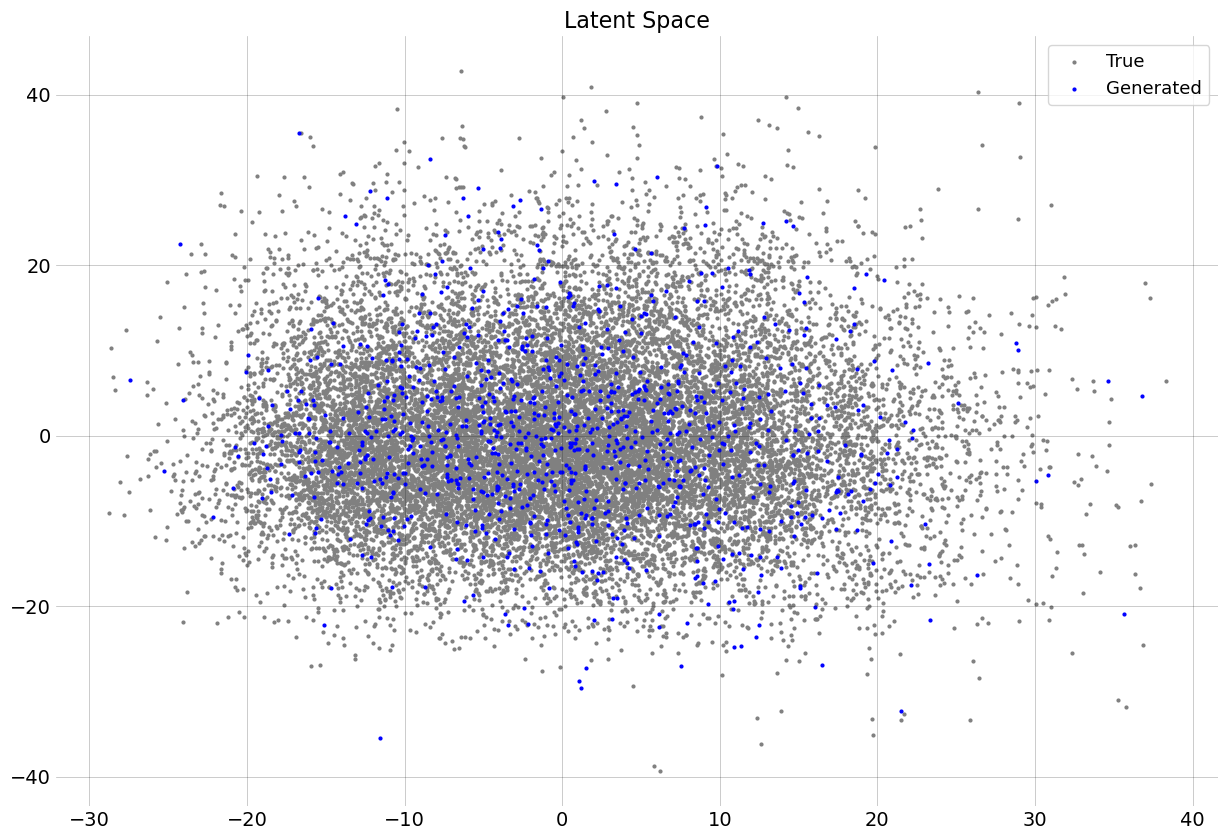

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_gen = 1000
Z = t.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded = pca.transform(Z)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10))

    ax.scatter(Z_embedded[:-n_gen, 0], Z_embedded[:-n_gen, 1], s=4, c ='grey', label = "True")
    ax.scatter(Z_embedded[-n_gen:, 0], Z_embedded[-n_gen:, 1], s=4, c='blue', label = "Generated")
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()

In [16]:
p = pca.inverse_transform(Z_embedded[Z_embedded[:,0] > 200])
t.decode(torch.Tensor(p))[0]

array([[  325.908   ,   356.39423 , 12797.148   , ...,   873.0858  ,
         1041.2499  ,    76.12998 ],
       [  325.5827  ,   353.32315 , 12805.783   , ...,   872.31287 ,
         1041.8959  ,    77.032875],
       [  324.9028  ,   357.33508 , 12690.234   , ...,   871.8885  ,
         1041.4695  ,    74.62958 ],
       ...,
       [  325.26495 ,   353.533   , 12788.921   , ...,   874.1059  ,
         1042.1144  ,    76.870125],
       [  325.5782  ,   352.62384 , 12823.481   , ...,   871.4426  ,
         1041.5815  ,    77.70898 ],
       [  321.9684  ,   342.73596 , 12577.905   , ...,   832.55164 ,
         1032.1062  ,    75.205   ]], dtype=float32)

# Reconstruction

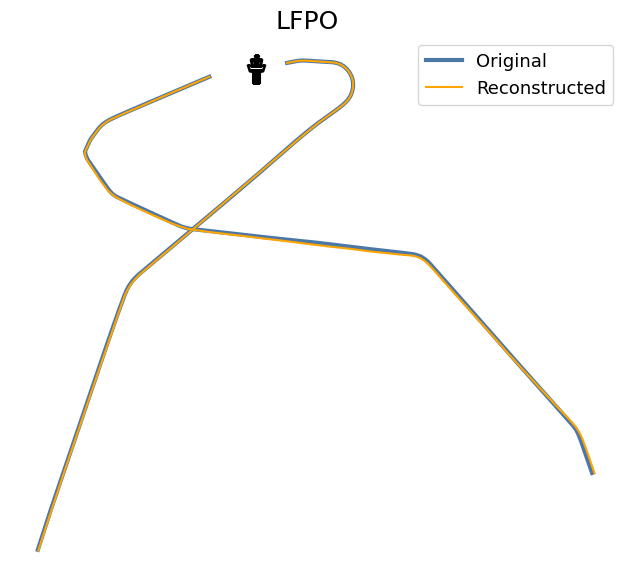

In [14]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import matplotlib.pyplot as plt

j = np.random.randint(len(dataset))

original1 = dataset.data1[j].unsqueeze(0)
original2 = dataset.data2[j].unsqueeze(0)
original1 = original1.transpose(1,2).reshape((original1.shape[0], -1))
original2 = original2.transpose(1,2).reshape((original2.shape[0], -1))
# original = torch.cat((dataset.delta_t[j].view(1,1), original1, original2), dim = 1)
original = torch.cat((original1, original2), dim = 1)
original = dataset.scaler.inverse_transform(original)
# original_traf_ld = g.build_traffic(original[:,1:801], coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
# original_traf_to = g.build_traffic(original[:,801:], coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)
original_traf_ld = g.build_traffic(original[:,:800], coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
original_traf_to = g.build_traffic(original[:,800:], coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)

h1 = t.VAE.encoder_traj1(dataset.data1[j].unsqueeze(0))
h2 = t.VAE.encoder_traj2(dataset.data2[j].unsqueeze(0))
# h = torch.cat((h1, h2, dataset.delta_t[j].view(1,1)), dim = 1)
h = torch.cat((h1, h2), dim = 1)
# h = t.VAE.encoder_delta_t(h)
z = t.VAE.lsr(h).rsample()
# dt, t1, t2 = t.decode(z)
t1, t2 = t.decode(z)
reconstructed_traf_ld = g.build_traffic(t1, coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
reconstructed_traf_to = g.build_traffic(t2, coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    original_traf_ld.plot(ax, c="#4c78a8", lw = 3, label = "Original")
    original_traf_to.plot(ax, c="#4c78a8", lw = 3)
    reconstructed_traf_ld.plot(ax, c="orange", label = "Reconstructed")
    reconstructed_traf_to.plot(ax, c="orange")
    plt.legend()

    airports["LFPO"].point.plot(ax, shift=dict(units="dots", x=20, y=40), text_kw= {"fontsize" : 18})

    plt.show()

# Generation

In [32]:
#Computing the pseudo inputs

#Vampprior
pseudo_X = t.VAE.lsr.pseudo_inputs_NN(t.VAE.lsr.idle_input) 
pseudo_X1 = pseudo_X[:,:800].view((pseudo_X.shape[0], 4, 200))
pseudo_X2 = pseudo_X[:,800:].view((pseudo_X.shape[0], 4, 200))

pseudo_h1 = t.VAE.encoder_traj1(pseudo_X1)
pseudo_h2 = t.VAE.encoder_traj2(pseudo_X2)
pseudo_h = torch.cat((pseudo_h1, pseudo_h2), dim = 1)

pseudo_means = t.VAE.lsr.z_loc(pseudo_h)
pseudo_scales = (t.VAE.lsr.z_log_var(pseudo_h) / 2).exp()

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries

t1, t2 = t.decode(pseudo_means)
t1[:,3] = 0
t2[:,3] = 0
gen_traf_ld = g.build_traffic(t1, coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
gen_traf_to = g.build_traffic(t2, coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)

z_train = t.latent_space(1)
Z = np.concatenate((z_train, pseudo_means.detach().numpy()), axis=0)
pca = PCA(n_components=2).fit(Z[:-len(pseudo_means)])
Z_embedded = pca.transform(Z)

/tmp/ipykernel_45867/2879701901.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(points, ax=ax0)


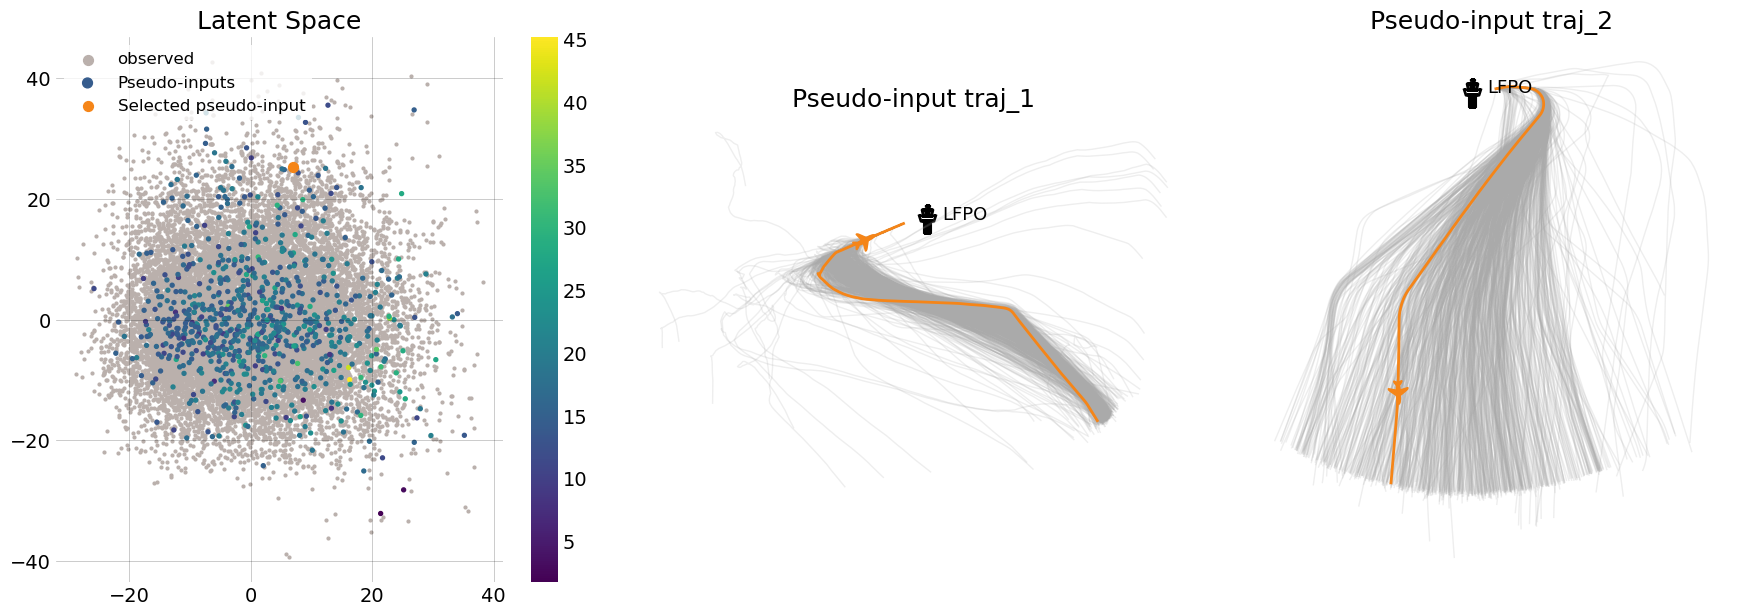

In [39]:
#col depending on the scales
col = torch.norm(pseudo_scales, dim = 1, p = 2).detach().numpy()

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(18, 12))
    ax0 = fig.add_subplot(231)
    ax1 = fig.add_subplot(232, projection=EuroPP())
    ax2 = fig.add_subplot(233, projection=EuroPP())

    k = np.random.randint(800)


    ax0.scatter(
        Z_embedded[:-len(pseudo_means), 0], Z_embedded[:-len(pseudo_means), 1], c="#bab0ac", s=4, label="observed"
    )
    points = ax0.scatter(
        Z_embedded[-len(pseudo_means):, 0],
        Z_embedded[-len(pseudo_means):, 1],
        s=8,
        c=col,
        cmap="viridis",
        label="Pseudo-inputs",
    )
    ax0.scatter(
        Z_embedded[z_train.shape[0]+k, 0],
        Z_embedded[z_train.shape[0]+k, 1],
        s=50,
        marker="o",
        c="#f58518",
        label="Selected pseudo-input",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    fig.colorbar(points, ax=ax0)

    ax1.set_title("Pseudo-input traj_1", fontsize=18)
    gen_traf_ld.plot(ax1, alpha=0.2)
    gen_traf_ld["TRAJ_" + str(k)].plot(ax1, color="#f58518", lw=2)
    gen_traf_ld["TRAJ_" + str(k)].at_ratio(0.85).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )
    
    ax2.set_title("Pseudo-input traj_2", fontsize=18)
    gen_traf_to.plot(ax2, alpha=0.2)
    gen_traf_to["TRAJ_" + str(k)].plot(ax2, color="#f58518", lw=2)
    gen_traf_to["TRAJ_" + str(k)].at_ratio(0.85).plot(
        ax2,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LFPO"].point.plot(ax1)
    airports["LFPO"].point.plot(ax2)
    fig.tight_layout()
    plt.show()

# Generation of one set of pairs

In [44]:
import pandas as pd

j = np.random.randint(0,800)
n_gen = 100

dist = torch.distributions.Independent(
    torch.distributions.Normal(pseudo_means[j], pseudo_scales[j]), 1
)
gen = dist.sample(torch.Size([n_gen]))

decode1, decode2 = t.decode(
    torch.cat((pseudo_means[j].unsqueeze(0), gen), axis=0)
)

# Neural net don't predict exaclty timedelta = 0 for the first observation
decode1[:, 3] = 0
decode2[:, 3] = 0

traf_gen1 = g.build_traffic(decode1, coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
traf_gen1 = traf_gen1.assign(gen_number=lambda x: 1)

traf_gen2 = g.build_traffic(decode2, coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)
traf_gen2 = traf_gen2.assign(gen_number=lambda x: 2)

z_train = t.latent_space(1)
gen = torch.cat((gen, pseudo_means[j].unsqueeze(0)), axis=0)
concat = np.concatenate((z_train, gen.detach().numpy()))
pca = PCA(n_components=2).fit(concat[: -len(gen)])
gen_embedded = pca.transform(concat)

gen_embedded = pd.DataFrame(gen_embedded, columns=["X1", "X2"])
gen_embedded["type"] = np.nan
gen_embedded.type[-(n_gen + 1) :] = "GEN"
gen_embedded.type[-1:] = "PI"

/tmp/ipykernel_45867/1024560945.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen_embedded.type[-(n_gen + 1) :] = "GEN"


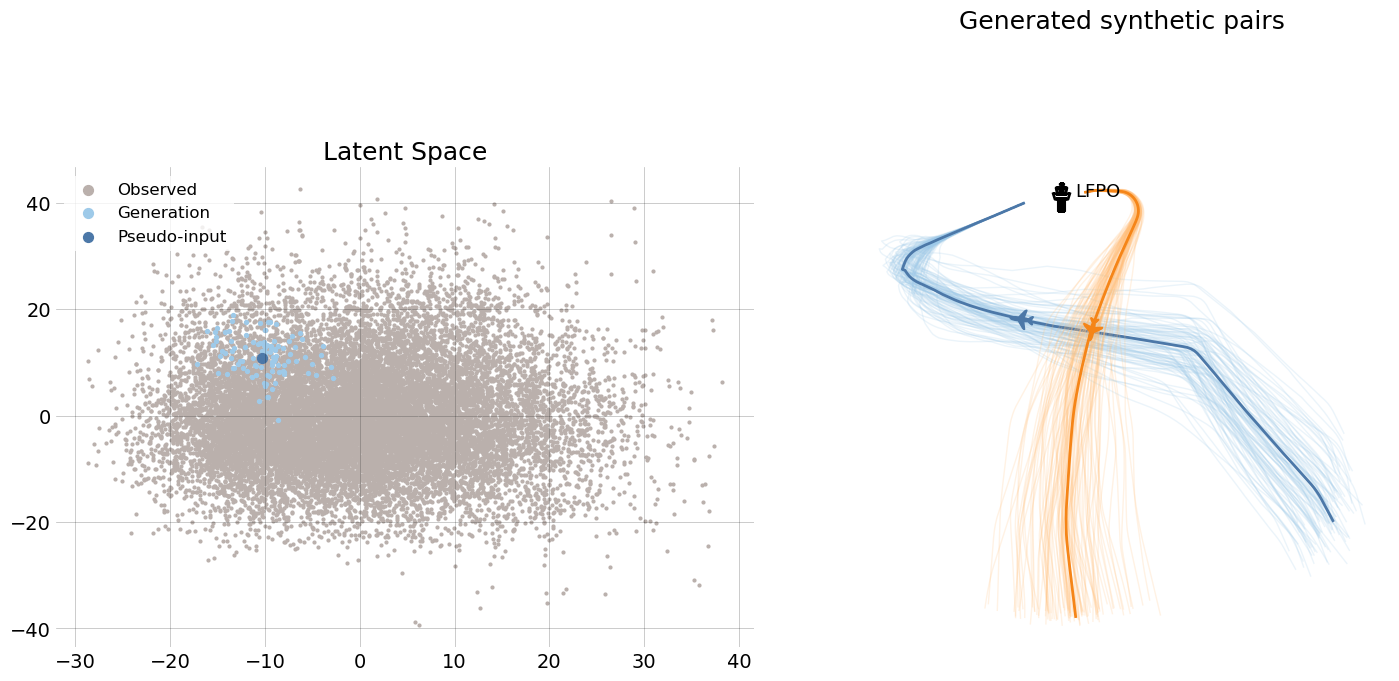

In [46]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 12))
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222, projection=EuroPP())

    ax0.scatter(
        gen_embedded.query("type.isnull()").X1,
        gen_embedded.query("type.isnull()").X2,
        c="#bab0ac",
        s=4,
        label="Observed",
    )
    ax0.scatter(
        gen_embedded.query("type == 'GEN'").X1,
        gen_embedded.query("type == 'GEN'").X2,
        c="#9ecae9",
        s=8,
        label="Generation",
    )
    ax0.scatter(
        gen_embedded.query("type == 'PI'").X1,
        gen_embedded.query("type == 'PI'").X2,
        c="#4c78a8",
        s=50,
        label="Pseudo-input",
    )
    ax0.set_title("Latent Space", fontsize=18)

    legend = ax0.legend(loc="upper left", fontsize=12)
    legend.get_frame().set_edgecolor("none")
    legend.legendHandles[0]._sizes = [50]
    legend.legendHandles[1]._sizes = [50]
    legend.legendHandles[2]._sizes = [50]

    ax1.set_title("Generated synthetic pairs", pad=100, fontsize=18)

    traf_gen1.plot(ax1, alpha=0.2, color="#9ecae9")
    traf_gen1["TRAJ_0"].plot(ax1, color="#4c78a8", lw=2)
    traf_gen1["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#4c78a8",
        zorder=5,
        text_kw={"s": None},
    )

    traf_gen2.plot(ax1, alpha=0.2, color="#ffbf79")
    traf_gen2["TRAJ_0"].plot(ax1, color="#f58518", lw=2)
    traf_gen2["TRAJ_0"].at_ratio(0.5).plot(
        ax1,
        color="#f58518",
        zorder=5,
        text_kw={"s": None},
    )

    airports["LFPO"].point.plot(ax1)
    fig.tight_layout()

    plt.show()